## Monte Carlo (MC) simulation of LJ particles in NVT ensemble

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit

Following function computes/returns potential energy of a single particle ...

In [6]:
@jit(nopython=True)
def potnrg_part(pos,i,boxl):
    '''
    Parameters
    ----------
    pos : array_like
        Coordinates of particles : N x ndim
    i : integer
        Particle number for which energy needs to be computed
    Returns
    -------
    nrg : float
    Energy of i-th particle
    '''
    sigma = 1.0
    eps   = 1.0
    r_cut = 4.0
    E_cut = 4*eps*((sigma/r_cut)**12 - (sigma/r_cut)**6)
    nrg = 0.0
    for j in range(len(pos)):
        if i != j:
            dpos = pos[i]-pos[j]
            # Perform transformation for minimum image convention (MIC)
            for comp in range(len(dpos)):
                if np.abs(dpos[comp]) > boxl/2.0:
                    dpos[comp] -= np.sign(dpos[comp])*boxl
            r = np.linalg.norm(dpos)
           
            if r <= r_cut:
                nrg += 4*eps*((sigma/r)**12 - (sigma/r)**6) - E_cut
    return nrg

Following function computes/returns total potential energy of the system ...

In [7]:
@jit(nopython=True)
def potnrg_total(pos,boxl):
    '''
    Parameters
    ----------
    pos : array_like
        Coordinates of particles : N x ndim

    Returns
    -------
    A tuple of total energy (totnrg) and energy of all particles (allnrg)
    '''
    allnrg = np.zeros(len(pos))
    sigma = 1.0
    eps   = 1.0
    r_cut = 4.0
    E_cut = 4*eps*((sigma/r_cut)**12 - (sigma/r_cut)**6)
    totnrg = 0.0
    for i in range(len(pos)-1):
        for j in range(i+1, len(pos)):
            dpos = pos[i]-pos[j]
            # Perform transformation for minimum image convention (MIC)
            for comp in range(len(dpos)):
                if np.abs(dpos[comp]) > boxl/2.0:
                    dpos[comp] -= np.sign(dpos[comp])*boxl
            r = np.linalg.norm(dpos)

            if r <= r_cut:
                nrg = 4*eps*((sigma/r)**12 - (sigma/r)**6) - E_cut
                totnrg += nrg
                allnrg[i] += nrg
                allnrg[j] += nrg
    return totnrg, allnrg


# Following function performs the actual MC simulation ...

In [9]:
@jit(nopython=True)
def MC_NVT(pos, boxl, kT=1.0, steps=1, equib=0, sampl_freq=1):
    print("Running MC for", steps, "steps ...")
    npart = len(pos)
    ndim = len(pos[0])
    maxl = 1.0 # Adjustable parameter ...
    potnrg = potnrg_total(pos,boxl)[0]
    accept = 0
    
    nsample = int((steps - equib)/sampl_freq)
    
    traj_nrg = np.zeros(nsample)
    traj_pos = np.zeros((nsample,npart,ndim))
    
    isampl = 0
    for step in range(steps):
        for _ in range(npart):
            part = np.random.randint(npart)
            oldnrg = potnrg_part(pos,part,boxl)
            dpos = np.random.uniform(-maxl,maxl,ndim)
            pos[part] += dpos
            pos = np.mod(pos,boxl) # Wrap particles due to PBC            
            newnrg = potnrg_part(pos,part,boxl)
            delnrg = newnrg - oldnrg
            if (np.random.uniform(0,1) < np.exp(-delnrg/kT)):
                potnrg += delnrg
                accept += 1
            else:
                pos[part] -= dpos
                pos = np.mod(pos,boxl)

        if ((step >= equib) and (step % sampl_freq == 0)):
            print("MC step:", step)
            traj_nrg[isampl] = potnrg
            traj_pos[isampl] = pos
            isampl += 1
    
    print("Acceptance = ", 100*(accept/(steps*npart)))
    return traj_pos, traj_nrg

The driver program ....

In [10]:
#Initialise ...
boxl = 5 # Unit of sigma
ndim = 2
npart = 64 # Number of particles
rho = npart/(boxl**ndim)
print("Density = ", rho)
# Initialise with random coordinates
pos = np.random.random((npart,ndim))*boxl 
traj_pos, traj_nrg = MC_NVT(pos, boxl, kT=2.0, steps=10000, equib=1000, sampl_freq=100)

Density =  2.56
Running MC for 10000 steps ...
MC step: 1000
MC step: 1100
MC step: 1200
MC step: 1300
MC step: 1400
MC step: 1500
MC step: 1600
MC step: 1700
MC step: 1800
MC step: 1900
MC step: 2000
MC step: 2100
MC step: 2200
MC step: 2300
MC step: 2400
MC step: 2500
MC step: 2600
MC step: 2700
MC step: 2800
MC step: 2900
MC step: 3000
MC step: 3100
MC step: 3200
MC step: 3300
MC step: 3400
MC step: 3500
MC step: 3600
MC step: 3700
MC step: 3800
MC step: 3900
MC step: 4000
MC step: 4100
MC step: 4200
MC step: 4300
MC step: 4400
MC step: 4500
MC step: 4600
MC step: 4700
MC step: 4800
MC step: 4900
MC step: 5000
MC step: 5100
MC step: 5200
MC step: 5300
MC step: 5400
MC step: 5500
MC step: 5600
MC step: 5700
MC step: 5800
MC step: 5900
MC step: 6000
MC step: 6100
MC step: 6200
MC step: 6300
MC step: 6400
MC step: 6500
MC step: 6600
MC step: 6700
MC step: 6800
MC step: 6900
MC step: 7000
MC step: 7100
MC step: 7200
MC step: 7300
MC step: 7400
MC step: 7500
MC step: 7600
MC step: 7700
M

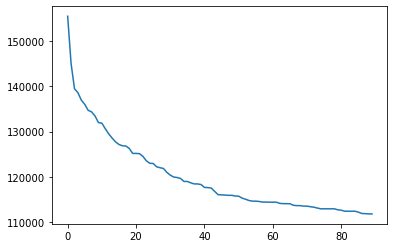

In [11]:
%matplotlib inline

# Plot energy versus MC steps ...
plt.plot(traj_nrg)

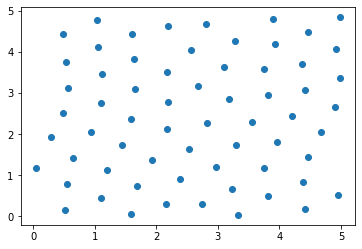

In [12]:
# Visualise final frame ...
plt.scatter(traj_pos[-1][:,0],traj_pos[-1][:,1])

In [13]:
@jit(nopython=True)
def RDF(pos,boxl,bw=0.01):
    steps = pos.shape[0]
    npart = pos.shape[1]
    ndim = pos.shape[2]

    rho = npart/(boxl**ndim)
    
    nbins = int(boxl/(2*bw))
    rdf = np.zeros(nbins)
    rbins = np.linspace(0,boxl/2,nbins) # Create grid/bins for r
    
    for step in range(steps):
        for i in range(npart):
            for j in range(npart):
                if i != j:
                    dpos = (pos[step][i]-pos[step][j])
                    # Perform transformation for minimum image convention (MIC)
                    for comp in range(len(dpos)):
                        if np.abs(dpos[comp]) > boxl/2.0:
                            dpos[comp] -= np.sign(dpos[comp])*boxl
                    r = np.linalg.norm(dpos)
                    if r <= boxl/2:
                        ibin = int(r / bw)
                        rdf[ibin] += 1
    if ndim == 3:
        rdf[1:] /= (4 * np.pi * rbins[1:]**2 * bw * rho * steps * npart) # for 3D RDF
    elif ndim == 2:
        rdf[1:] /= (2 * np.pi * rbins[1:] * bw * rho * steps * npart) # for 2D RDF
    else:
        print("Dimensionality not supported!")
        return None
    return rbins[1:], rdf[1:]

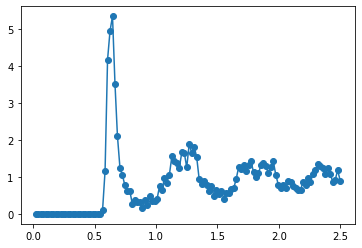

In [14]:
rbins, rdf = RDF(traj_pos,boxl,bw=0.02)
plt.plot(rbins, rdf,'-o')